# Unrolled generative adversarial networks on a toy dataset

This notebook demos a simple implementation of unrolled generative adversarial networks on a 2d mixture of Gaussians dataset. See the [paper](https://arxiv.org/abs/1611.02163) for a better description of the technique, experiments, results, and other good stuff. Note that the architecture and hyperparameters used in this notebook are not identical to the one in the paper.

## Motivation
The GAN learning problem is to find the optimal parameters $\theta_G^*$ for a generator function $G\left( z; \theta_G\right)$ in a minimax objective, 
$$\begin{align} 
    \theta_G^* &= \underset{\theta_G}{\text{argmin}} \underset{\theta_D}{\max} f\left(\theta_G, \theta_D\right) \\
&= \underset{\theta_G}{\text{argmin}} \;f\left(\theta_G, \theta_D^*\left(\theta_G\right)\right)\\
\theta_D^*\left(\theta_G\right) &= \underset{\theta_D}{\max}  \;f\left(\theta_G, \theta_D\right),
\end{align}$$
where the saddle objective $f$ is the standard GAN loss:
$$f\left(\theta_G, \theta_D\right) = 
    \mathbb{E}_{x\sim p_{data}}\left[\mathrm{log}\left(D\left(x; \theta_D\right)\right)\right] +
    \mathbb{E}_{z \sim \mathcal{N}(0,I)}\left[\mathrm{log}\left(1 - D\left(G\left(z; \theta_G\right); \theta_D\right)\right)\right].
$$

In unrolled GANs, we approximate $\theta_D^*\left(\theta_G\right)$ using a few steps of gradient ascent:
$$\theta_D^*\left(\theta_G\right) \approx \hat{\theta}_D\left(\theta_G\right) \equiv\text{ a few steps of SGD maximizing}\;f\left(\theta_G, \theta_D\right).$$

We can then compute the update for the generator parameters, $\theta_G$, by computing the gradient of the saddle objective with respect to $\theta_G$ and the optimized discriminator parameters, $\hat{\theta}_D$:
$$\frac{d}{d \theta_G} f\left(\theta_G, \hat{\theta}_D\left(\theta_G\right)\right)$$.

## Implementation details
To backpropagate through the optimization process, we need to create a symbolic computational graph that includes all the operations from the initial weights to the optimized weights. TensorFlow's built-in optimizers use custom C++ code for efficiency, and do not construct a symbolic graph that is differentiable. For this notebook, we use the optimization routines from `keras` to compute updates.  Next, we use `tf.contrib.graph_editor.graph_replace` to build a copy of the graph containing the mapping from initial weights to updated weights after one optimization iteration, but replacing the initial weights with the last iteration's weights:

![](https://cloud.githubusercontent.com/assets/718528/21964677/60bb94ea-db05-11e6-9e2d-9f7de280517e.png)

This yields a new graph that allows us to backprop from $\theta_D^2$ back to $\theta_D^0$. We can then plug $\theta_D^2$ into the loss function to get the final objective that the generator optimizes. Using the magic of `graph_replace` we can write the unrolled optimization procedure in just a few lines:
```python
# update_dict contains a dicitonary mapping from variables (\theta_D^0)
# to their values after one step of optimization (\theta_D^1)
cur_update_dict = update_dict
for i in xrange(params['unrolling_steps'] - 1):
    # Compute variable updates given the previous iteration's updated variable
    cur_update_dict = graph_replace(update_dict, cur_update_dict)
# Final unrolled loss uses the parameters at the last time step
unrolled_loss = graph_replace(loss, cur_update_dict)
```

Note there are many other ways of implementing unrolled optimization that don't use graph rewriting. For example, if we created a function that takes weights as inputs and returns the updated weights, we could just iteratively call that function.

In [1]:
%pylab inline
from collections import OrderedDict
import tensorflow as tf
ds = tf.contrib.distributions
slim = tf.contrib.slim
        
from keras.optimizers import Adam

try:
    from moviepy.video.io.bindings import mplfig_to_npimage
    import moviepy.editor as mpy
    generate_movie = True
except:
    print("Warning: moviepy not found.")
    generate_movie = False

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


`graph_replace` is broken in TensorFlow 1.0 (see this [issue](https://github.com/tensorflow/tensorflow/issues/9125)). We get around this issue with an ugly hack that removes the problematic attribute from all ops in the graph on every call to `graph_replace`.

In [2]:
_graph_replace = tf.contrib.graph_editor.graph_replace

def remove_original_op_attributes(graph):
    """Remove _original_op attribute from all operations in a graph."""
    for op in graph.get_operations():
        op._original_op = None
        
def graph_replace(*args, **kwargs):
    """Monkey patch graph_replace so that it works with TF 1.0"""
    remove_original_op_attributes(tf.get_default_graph())
    return _graph_replace(*args, **kwargs)

### Utility functions

In [3]:
def extract_update_dict(update_ops):
    """Extract variables and their new values from Assign and AssignAdd ops.
    
    Args:
        update_ops: list of Assign and AssignAdd ops, typically computed using Keras' opt.get_updates()

    Returns:
        dict mapping from variable values to their updated value
    """
    name_to_var = {v.name: v for v in tf.global_variables()}
    updates = OrderedDict()
    for update in update_ops:
        var_name = update.op.inputs[0].name
        var = name_to_var[var_name]
        value = update.op.inputs[1]
        if update.op.type == 'Assign':
            updates[var.value()] = value
        elif update.op.type == 'AssignAdd':
            updates[var.value()] = var + value
        else:
            raise ValueError("Update op type (%s) must be of type Assign or AssignAdd"%update_op.op.type)
    return updates

### Data creation

In [4]:
def sample_mog(batch_size, n_mixture=8, std=0.02, radius=2.0):
    thetas = np.linspace(0, 2 * np.pi, n_mixture + 1)[:n_mixture]
    xs, ys = radius * np.sin(thetas), radius * np.cos(thetas)
    cat = ds.Categorical(tf.zeros(n_mixture))
    comps = [ds.MultivariateNormalDiag([xi, yi], [std, std]) for xi, yi in zip(xs.ravel(), ys.ravel())]
    data = ds.Mixture(cat, comps)
    return data.sample(batch_size)

### Generator and discriminator architectures

In [5]:
def generator(z, output_dim=2, n_hidden=128, n_layer=2):
    with tf.variable_scope("generator"):
        h = slim.stack(z, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        x = slim.fully_connected(h, output_dim, activation_fn=None)
    return x

def discriminator(x, n_hidden=128, n_layer=1, reuse=False):
    with tf.variable_scope("discriminator", reuse=reuse):
        x = x / 4
        h = slim.stack(x, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=None)
    return log_d

### Hyperparameters

In [6]:
params = dict(
    batch_size=512,
    disc_learning_rate=1e-4,
    gen_learning_rate=1e-4,
    beta1=0.5,
    epsilon=1e-8,
    max_iter=25000,
    viz_every=5000,
    z_dim=256,
    x_dim=2,
    unrolling_steps=10,
)

## Construct model and training ops

In [7]:
tf.reset_default_graph()

data = sample_mog(params['batch_size'])

noise = ds.Normal(tf.zeros(params['z_dim']), 
                  tf.ones(params['z_dim'])).sample(params['batch_size'])
# Construct generator and discriminator nets

with slim.arg_scope([slim.fully_connected], weights_initializer=tf.orthogonal_initializer(gain=0.8)):
    samples = generator(noise, output_dim=params['x_dim'])
    
with slim.arg_scope([slim.fully_connected], weights_initializer=tf.random_normal_initializer(stddev=0.01)):
    real_score = discriminator(data)  # n_layer=2
    fake_score = discriminator(samples, reuse=True)  # n_layer=2
#     real_score = discriminator(data, n_layer=1)
#     fake_score = discriminator(samples, n_layer=1, reuse=True)
    
# Saddle objective    
loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score, labels=tf.ones_like(real_score)) +
    tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score, labels=tf.zeros_like(fake_score)))

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")

# Vanilla discriminator update
d_opt = Adam(lr=params['disc_learning_rate'], beta_1=params['beta1'], epsilon=params['epsilon'])
updates = d_opt.get_updates(disc_vars, [], loss)
d_train_op = tf.group(*updates, name="d_train_op")

# Unroll optimization of the discrimiantor
if params['unrolling_steps'] > 0:
    # Get dictionary mapping from variables to their update value after one optimization step
    update_dict = extract_update_dict(updates)
    cur_update_dict = update_dict
    for i in range(params['unrolling_steps'] - 1):
        # Compute variable updates given the previous iteration's updated variable
        cur_update_dict = graph_replace(update_dict, cur_update_dict)
    # Final unrolled loss uses the parameters at the last time step
    unrolled_loss = graph_replace(loss, cur_update_dict)
else:
    unrolled_loss = loss

# Optimize the generator on the unrolled loss
g_train_opt = tf.train.AdamOptimizer(params['gen_learning_rate'], beta1=params['beta1'], epsilon=params['epsilon'])
g_train_op = g_train_opt.minimize(-unrolled_loss, var_list=gen_vars)

INFO:tensorflow:Copying op: discriminator/fully_connected/BiasAdd
INFO:tensorflow:Copying op: mul_1
INFO:tensorflow:Copying op: sub_13
INFO:tensorflow:Copying op: sub_10
INFO:tensorflow:Copying op: add_1
INFO:tensorflow:Copying op: gradients/discriminator/fully_connected/MatMul_grad/MatMul
INFO:tensorflow:Copying op: mul_8
INFO:tensorflow:Copying op: mul_13
INFO:tensorflow:Copying op: gradients/discriminator_1/fully_connected/MatMul_grad/MatMul
INFO:tensorflow:Copying op: mul_11
INFO:tensorflow:Copying op: mul_6
INFO:tensorflow:Copying op: sub_4
INFO:tensorflow:Copying op: mul_18
INFO:tensorflow:Copying op: discriminator/fully_connected/MatMul
INFO:tensorflow:Copying op: discriminator/Stack/fully_connected_1/MatMul
INFO:tensorflow:Copying op: sub_7
INFO:tensorflow:Copying op: add_14
INFO:tensorflow:Copying op: discriminator_1/fully_connected/MatMul
INFO:tensorflow:Copying op: discriminator/Stack/fully_connected_1/BiasAdd
INFO:tensorflow:Copying op: discriminator_1/fully_connected/BiasA

INFO:tensorflow:Copying op: add_8
INFO:tensorflow:Copying op: add_5
INFO:tensorflow:Copying op: gradients/discriminator_1/Stack/fully_connected_1/Relu_grad/ReluGrad
INFO:tensorflow:Copying op: add_6
INFO:tensorflow:Copying op: Pow
INFO:tensorflow:Copying op: add_9
INFO:tensorflow:Copying op: Pow_1
INFO:tensorflow:Copying op: discriminator_1/Stack/fully_connected_1/Relu
INFO:tensorflow:Copying op: logistic_loss/GreaterEqual
INFO:tensorflow:Copying op: logistic_loss_1/Neg
INFO:tensorflow:Copying op: logistic_loss/Neg
INFO:tensorflow:Copying op: add_11
INFO:tensorflow:Copying op: add_12
INFO:tensorflow:Copying op: gradients/logistic_loss/Select_grad/zeros_like
INFO:tensorflow:Copying op: logistic_loss/zeros_like
INFO:tensorflow:Copying op: logistic_loss_1/Select_1
INFO:tensorflow:Copying op: discriminator/Stack/fully_connected_1/Relu
INFO:tensorflow:Copying op: add_2
INFO:tensorflow:Copying op: logistic_loss/Select_1
INFO:tensorflow:Copying op: zeros_like
INFO:tensorflow:Copying op: gradi

INFO:tensorflow:Copying op: gradients/logistic_loss/Select_1_grad/Select_1
INFO:tensorflow:Copying op: mul_5
INFO:tensorflow:Copying op: gradients/logistic_loss_1/mul_grad/mul
INFO:tensorflow:Copying op: gradients/discriminator/Stack/fully_connected_1/BiasAdd_grad/BiasAddGrad
INFO:tensorflow:Copying op: gradients/logistic_loss/Select_grad/Select
INFO:tensorflow:Copying op: gradients/discriminator_1/Stack/fully_connected_1/MatMul_grad/MatMul_1
INFO:tensorflow:Copying op: gradients/discriminator/fully_connected/MatMul_grad/MatMul_1
INFO:tensorflow:Copying op: mul_10
INFO:tensorflow:Copying op: gradients/discriminator_1/Stack/fully_connected_1/BiasAdd_grad/BiasAddGrad
INFO:tensorflow:Copying op: mul_15
INFO:tensorflow:Copying op: gradients/logistic_loss/Select_1_grad/zeros_like
INFO:tensorflow:Copying op: clip_by_value_1/Minimum
INFO:tensorflow:Copying op: sub
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Select_1_grad/Select
INFO:tensorflow:Copying op: gradients/discriminator_1/f

INFO:tensorflow:Copying op: gradients/discriminator/Stack/fully_connected_1/MatMul_grad/MatMul_1
INFO:tensorflow:Copying op: clip_by_value_3/Minimum
INFO:tensorflow:Copying op: gradients/logistic_loss/Neg_grad/Neg
INFO:tensorflow:Copying op: gradients/logistic_loss_1/mul_grad/Sum
INFO:tensorflow:Copying op: clip_by_value_3
INFO:tensorflow:Copying op: clip_by_value_4
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Neg_grad/Neg
INFO:tensorflow:Copying op: gradients/AddN_3
INFO:tensorflow:Copying op: truediv_1
INFO:tensorflow:Copying op: gradients/AddN
INFO:tensorflow:Copying op: gradients/AddN_5
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Log1p_grad/add
INFO:tensorflow:Copying op: truediv_2
INFO:tensorflow:Copying op: gradients/AddN_4
INFO:tensorflow:Copying op: clip_by_value_1
INFO:tensorflow:Copying op: gradients/logistic_loss/Log1p_grad/add
INFO:tensorflow:Copying op: truediv_4
INFO:tensorflow:Copying op: truediv_3
INFO:tensorflow:Copying op: gradients/logistic_loss/Ex

INFO:tensorflow:Copying op: Sqrt_1
INFO:tensorflow:Copying op: mul_2
INFO:tensorflow:Copying op: gradients/logistic_loss_1/mul_grad/Reshape
INFO:tensorflow:Copying op: Square_2
INFO:tensorflow:Copying op: mul_7
INFO:tensorflow:Copying op: Square
INFO:tensorflow:Copying op: clip_by_value
INFO:tensorflow:Copying op: mul_12
INFO:tensorflow:Copying op: Sqrt_3
INFO:tensorflow:Copying op: Square_1
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Log1p_grad/Reciprocal
INFO:tensorflow:Copying op: mul
INFO:tensorflow:Copying op: gradients/logistic_loss/Log1p_grad/Reciprocal
INFO:tensorflow:Copying op: gradients/discriminator_1/fully_connected/BiasAdd_grad/BiasAddGrad
INFO:tensorflow:Copying op: gradients/discriminator/fully_connected/BiasAdd_grad/BiasAddGrad
INFO:tensorflow:Copying op: Sqrt_4
INFO:tensorflow:Copying op: Sqrt_2
INFO:tensorflow:Copying op: mul_14
INFO:tensorflow:Copying op: add_13
INFO:tensorflow:Copying op: Sqrt
INFO:tensorflow:Copying op: add_10
INFO:tensorflow:Copying op:

INFO:tensorflow:Copying op: add_4
INFO:tensorflow:Copying op: mul_4
INFO:tensorflow:Copying op: gradients/AddN_2
INFO:tensorflow:Copying op: Square_3
INFO:tensorflow:Copying op: mul_17
INFO:tensorflow:Copying op: mul_19
INFO:tensorflow:Finalizing op: discriminator/fully_connected/BiasAdd
INFO:tensorflow:Finalizing op: mul_1
INFO:tensorflow:Finalizing op: sub_13
INFO:tensorflow:Finalizing op: sub_10
INFO:tensorflow:Finalizing op: add_1
INFO:tensorflow:Finalizing op: gradients/discriminator/fully_connected/MatMul_grad/MatMul
INFO:tensorflow:Finalizing op: mul_8
INFO:tensorflow:Finalizing op: mul_13
INFO:tensorflow:Finalizing op: gradients/discriminator_1/fully_connected/MatMul_grad/MatMul
INFO:tensorflow:Finalizing op: mul_11
INFO:tensorflow:Finalizing op: mul_6
INFO:tensorflow:Finalizing op: sub_4
INFO:tensorflow:Finalizing op: mul_18
INFO:tensorflow:Finalizing op: discriminator/fully_connected/MatMul
INFO:tensorflow:Finalizing op: discriminator/Stack/fully_connected_1/MatMul
INFO:tenso

INFO:tensorflow:Finalizing op: gradients/discriminator/fully_connected/BiasAdd_grad/BiasAddGrad
INFO:tensorflow:Finalizing op: Sqrt_4
INFO:tensorflow:Finalizing op: Sqrt_2
INFO:tensorflow:Finalizing op: mul_14
INFO:tensorflow:Finalizing op: add_13
INFO:tensorflow:Finalizing op: Sqrt
INFO:tensorflow:Finalizing op: add_10
INFO:tensorflow:Finalizing op: add_7
INFO:tensorflow:Finalizing op: gradients/logistic_loss/Log1p_grad/mul
INFO:tensorflow:Finalizing op: gradients/logistic_loss_1/Log1p_grad/mul
INFO:tensorflow:Finalizing op: mul_9
INFO:tensorflow:Finalizing op: add_4
INFO:tensorflow:Finalizing op: mul_4
INFO:tensorflow:Finalizing op: gradients/AddN_2
INFO:tensorflow:Finalizing op: Square_3
INFO:tensorflow:Finalizing op: mul_17
INFO:tensorflow:Finalizing op: mul_19
INFO:tensorflow:Copying op: discriminator/fully_connected/BiasAdd
INFO:tensorflow:Copying op: mul_1
INFO:tensorflow:Copying op: sub_13
INFO:tensorflow:Copying op: sub_10
INFO:tensorflow:Copying op: add_1
INFO:tensorflow:Copy

INFO:tensorflow:Copying op: mul_16
INFO:tensorflow:Copying op: gradients/discriminator/Stack/fully_connected_1/Relu_grad/ReluGrad
INFO:tensorflow:Copying op: add_8
INFO:tensorflow:Copying op: add_5
INFO:tensorflow:Copying op: gradients/discriminator_1/Stack/fully_connected_1/Relu_grad/ReluGrad
INFO:tensorflow:Copying op: add_6
INFO:tensorflow:Copying op: Pow
INFO:tensorflow:Copying op: add_9
INFO:tensorflow:Copying op: Pow_1
INFO:tensorflow:Copying op: logistic_loss/GreaterEqual
INFO:tensorflow:Copying op: discriminator_1/Stack/fully_connected_1/Relu
INFO:tensorflow:Copying op: logistic_loss/Neg
INFO:tensorflow:Copying op: add_12
INFO:tensorflow:Copying op: logistic_loss_1/Neg
INFO:tensorflow:Copying op: add_11
INFO:tensorflow:Copying op: gradients/logistic_loss/Select_grad/zeros_like
INFO:tensorflow:Copying op: logistic_loss/zeros_like
INFO:tensorflow:Copying op: logistic_loss_1/Select_1
INFO:tensorflow:Copying op: discriminator/Stack/fully_connected_1/Relu
INFO:tensorflow:Copying op:

INFO:tensorflow:Copying op: logistic_loss_1/zeros_like
INFO:tensorflow:Copying op: clip_by_value_4/Minimum
INFO:tensorflow:Copying op: gradients/logistic_loss/Select_1_grad/Select_1
INFO:tensorflow:Copying op: mul_5
INFO:tensorflow:Copying op: gradients/logistic_loss_1/mul_grad/mul
INFO:tensorflow:Copying op: gradients/discriminator/Stack/fully_connected_1/BiasAdd_grad/BiasAddGrad
INFO:tensorflow:Copying op: gradients/logistic_loss/Select_grad/Select
INFO:tensorflow:Copying op: gradients/discriminator_1/Stack/fully_connected_1/MatMul_grad/MatMul_1
INFO:tensorflow:Copying op: gradients/discriminator/fully_connected/MatMul_grad/MatMul_1
INFO:tensorflow:Copying op: mul_10
INFO:tensorflow:Copying op: gradients/discriminator_1/Stack/fully_connected_1/BiasAdd_grad/BiasAddGrad
INFO:tensorflow:Copying op: mul_15
INFO:tensorflow:Copying op: gradients/logistic_loss/Select_1_grad/zeros_like
INFO:tensorflow:Copying op: sub
INFO:tensorflow:Copying op: clip_by_value_1/Minimum
INFO:tensorflow:Copying

INFO:tensorflow:Copying op: gradients/logistic_loss_1/Select_grad/Select
INFO:tensorflow:Copying op: gradients/logistic_loss/Select_1_grad/Select
INFO:tensorflow:Copying op: logistic_loss/Exp
INFO:tensorflow:Copying op: gradients/discriminator/Stack/fully_connected_1/MatMul_grad/MatMul_1
INFO:tensorflow:Copying op: clip_by_value_3/Minimum
INFO:tensorflow:Copying op: gradients/logistic_loss/Neg_grad/Neg
INFO:tensorflow:Copying op: truediv
INFO:tensorflow:Copying op: gradients/logistic_loss_1/mul_grad/Sum
INFO:tensorflow:Copying op: clip_by_value_3
INFO:tensorflow:Copying op: clip_by_value_4
INFO:tensorflow:Copying op: gradients/AddN_3
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Neg_grad/Neg
INFO:tensorflow:Copying op: truediv_1
INFO:tensorflow:Copying op: gradients/AddN
INFO:tensorflow:Copying op: gradients/AddN_5
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Log1p_grad/add
INFO:tensorflow:Copying op: truediv_2
INFO:tensorflow:Copying op: gradients/AddN_4
INFO:tensorfl

INFO:tensorflow:Copying op: gradients/AddN_1
INFO:tensorflow:Copying op: clip_by_value_2
INFO:tensorflow:Copying op: clip_by_value/Minimum
INFO:tensorflow:Copying op: Sqrt_1
INFO:tensorflow:Copying op: clip_by_value
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Log1p_grad/Reciprocal
INFO:tensorflow:Copying op: gradients/logistic_loss/Log1p_grad/Reciprocal
INFO:tensorflow:Copying op: gradients/discriminator_1/fully_connected/BiasAdd_grad/BiasAddGrad
INFO:tensorflow:Copying op: gradients/discriminator/fully_connected/BiasAdd_grad/BiasAddGrad
INFO:tensorflow:Copying op: Sqrt_2
INFO:tensorflow:Copying op: gradients/logistic_loss_1/mul_grad/Reshape
INFO:tensorflow:Copying op: mul_7
INFO:tensorflow:Copying op: Sqrt_4
INFO:tensorflow:Copying op: Sqrt_3
INFO:tensorflow:Copying op: mul_2
INFO:tensorflow:Copying op: Square
INFO:tensorflow:Copying op: Square_1
INFO:tensorflow:Copying op: Square_2
INFO:tensorflow:Copying op: mul
INFO:tensorflow:Copying op: mul_12
INFO:tensorflow:Copying op

INFO:tensorflow:Copying op: add_4
INFO:tensorflow:Copying op: add_7
INFO:tensorflow:Copying op: mul_4
INFO:tensorflow:Copying op: add_13
INFO:tensorflow:Copying op: add_10
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Log1p_grad/mul
INFO:tensorflow:Copying op: mul_17
INFO:tensorflow:Copying op: Square_3
INFO:tensorflow:Copying op: mul_19
INFO:tensorflow:Finalizing op: discriminator/fully_connected/BiasAdd
INFO:tensorflow:Finalizing op: mul_1
INFO:tensorflow:Finalizing op: sub_13
INFO:tensorflow:Finalizing op: sub_10
INFO:tensorflow:Finalizing op: add_1
INFO:tensorflow:Finalizing op: gradients/discriminator/fully_connected/MatMul_grad/MatMul
INFO:tensorflow:Finalizing op: mul_8
INFO:tensorflow:Finalizing op: mul_13
INFO:tensorflow:Finalizing op: gradients/discriminator_1/fully_connected/MatMul_grad/MatMul
INFO:tensorflow:Finalizing op: mul_11
INFO:tensorflow:Finalizing op: mul_6
INFO:tensorflow:Finalizing op: sub_4
INFO:tensorflow:Finalizing op: mul_18
INFO:tensorflow:Finalizing

INFO:tensorflow:Finalizing op: truediv_3
INFO:tensorflow:Finalizing op: gradients/logistic_loss/Exp_grad/mul
INFO:tensorflow:Finalizing op: gradients/logistic_loss_1/Exp_grad/mul
INFO:tensorflow:Finalizing op: gradients/AddN_1
INFO:tensorflow:Finalizing op: clip_by_value_2
INFO:tensorflow:Finalizing op: clip_by_value/Minimum
INFO:tensorflow:Finalizing op: Sqrt_1
INFO:tensorflow:Finalizing op: clip_by_value
INFO:tensorflow:Finalizing op: gradients/logistic_loss_1/Log1p_grad/Reciprocal
INFO:tensorflow:Finalizing op: gradients/logistic_loss/Log1p_grad/Reciprocal
INFO:tensorflow:Finalizing op: gradients/discriminator_1/fully_connected/BiasAdd_grad/BiasAddGrad
INFO:tensorflow:Finalizing op: gradients/discriminator/fully_connected/BiasAdd_grad/BiasAddGrad
INFO:tensorflow:Finalizing op: Sqrt_2
INFO:tensorflow:Finalizing op: gradients/logistic_loss_1/mul_grad/Reshape
INFO:tensorflow:Finalizing op: mul_7
INFO:tensorflow:Finalizing op: Sqrt_4
INFO:tensorflow:Finalizing op: Sqrt_3
INFO:tensorflow

INFO:tensorflow:Copying op: discriminator_1/Stack/fully_connected_1/MatMul
INFO:tensorflow:Copying op: mul_3
INFO:tensorflow:Copying op: discriminator_1/Stack/fully_connected_1/BiasAdd
INFO:tensorflow:Copying op: mul_16
INFO:tensorflow:Copying op: gradients/discriminator/Stack/fully_connected_1/Relu_grad/ReluGrad
INFO:tensorflow:Copying op: add_8
INFO:tensorflow:Copying op: add_5
INFO:tensorflow:Copying op: gradients/discriminator_1/Stack/fully_connected_1/Relu_grad/ReluGrad
INFO:tensorflow:Copying op: add_6
INFO:tensorflow:Copying op: Pow
INFO:tensorflow:Copying op: add_9
INFO:tensorflow:Copying op: Pow_1
INFO:tensorflow:Copying op: logistic_loss/GreaterEqual
INFO:tensorflow:Copying op: discriminator_1/Stack/fully_connected_1/Relu
INFO:tensorflow:Copying op: logistic_loss/Neg
INFO:tensorflow:Copying op: add_12
INFO:tensorflow:Copying op: logistic_loss_1/Neg
INFO:tensorflow:Copying op: add_11
INFO:tensorflow:Copying op: gradients/logistic_loss/Select_grad/zeros_like
INFO:tensorflow:Cop

INFO:tensorflow:Copying op: zeros_like
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Select_grad/zeros_like
INFO:tensorflow:Copying op: add_3
INFO:tensorflow:Copying op: logistic_loss_1/GreaterEqual
INFO:tensorflow:Copying op: logistic_loss_1/zeros_like
INFO:tensorflow:Copying op: gradients/logistic_loss/Select_1_grad/Select_1
INFO:tensorflow:Copying op: clip_by_value_4/Minimum
INFO:tensorflow:Copying op: mul_5
INFO:tensorflow:Copying op: gradients/logistic_loss_1/mul_grad/mul
INFO:tensorflow:Copying op: gradients/discriminator/Stack/fully_connected_1/BiasAdd_grad/BiasAddGrad
INFO:tensorflow:Copying op: gradients/logistic_loss/Select_grad/Select
INFO:tensorflow:Copying op: gradients/discriminator_1/Stack/fully_connected_1/MatMul_grad/MatMul_1
INFO:tensorflow:Copying op: gradients/discriminator/fully_connected/MatMul_grad/MatMul_1
INFO:tensorflow:Copying op: mul_10
INFO:tensorflow:Copying op: gradients/discriminator_1/Stack/fully_connected_1/BiasAdd_grad/BiasAddGrad
INFO:tensorf

INFO:tensorflow:Copying op: logistic_loss_1/Exp
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Select_1_grad/Select_1
INFO:tensorflow:Copying op: clip_by_value_2/Minimum
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Select_grad/Select
INFO:tensorflow:Copying op: gradients/logistic_loss/Select_1_grad/Select
INFO:tensorflow:Copying op: logistic_loss/Exp
INFO:tensorflow:Copying op: gradients/discriminator/Stack/fully_connected_1/MatMul_grad/MatMul_1
INFO:tensorflow:Copying op: clip_by_value_3/Minimum
INFO:tensorflow:Copying op: gradients/logistic_loss/Neg_grad/Neg
INFO:tensorflow:Copying op: truediv
INFO:tensorflow:Copying op: gradients/logistic_loss_1/mul_grad/Sum
INFO:tensorflow:Copying op: clip_by_value_3
INFO:tensorflow:Copying op: clip_by_value_4
INFO:tensorflow:Copying op: gradients/AddN_3
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Neg_grad/Neg
INFO:tensorflow:Copying op: truediv_1
INFO:tensorflow:Copying op: gradients/AddN
INFO:tensorflow:Copying op: gradi

INFO:tensorflow:Copying op: gradients/logistic_loss/Exp_grad/mul
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Exp_grad/mul
INFO:tensorflow:Copying op: gradients/AddN_1
INFO:tensorflow:Copying op: clip_by_value/Minimum
INFO:tensorflow:Copying op: clip_by_value_2
INFO:tensorflow:Copying op: Sqrt_1
INFO:tensorflow:Copying op: clip_by_value
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Log1p_grad/Reciprocal
INFO:tensorflow:Copying op: gradients/logistic_loss/Log1p_grad/Reciprocal
INFO:tensorflow:Copying op: gradients/discriminator_1/fully_connected/BiasAdd_grad/BiasAddGrad
INFO:tensorflow:Copying op: gradients/discriminator/fully_connected/BiasAdd_grad/BiasAddGrad
INFO:tensorflow:Copying op: Sqrt_2
INFO:tensorflow:Copying op: gradients/logistic_loss_1/mul_grad/Reshape
INFO:tensorflow:Copying op: mul_7
INFO:tensorflow:Copying op: Sqrt_4
INFO:tensorflow:Copying op: Sqrt_3
INFO:tensorflow:Copying op: mul_2
INFO:tensorflow:Copying op: Square
INFO:tensorflow:Copying op: Square_

INFO:tensorflow:Copying op: mul_14
INFO:tensorflow:Copying op: Sqrt
INFO:tensorflow:Copying op: add_4
INFO:tensorflow:Copying op: add_7
INFO:tensorflow:Copying op: mul_4
INFO:tensorflow:Copying op: add_13
INFO:tensorflow:Copying op: add_10
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Log1p_grad/mul
INFO:tensorflow:Copying op: mul_17
INFO:tensorflow:Copying op: Square_3
INFO:tensorflow:Copying op: mul_19
INFO:tensorflow:Finalizing op: discriminator/fully_connected/BiasAdd
INFO:tensorflow:Finalizing op: mul_1
INFO:tensorflow:Finalizing op: sub_13
INFO:tensorflow:Finalizing op: sub_10
INFO:tensorflow:Finalizing op: add_1
INFO:tensorflow:Finalizing op: gradients/discriminator/fully_connected/MatMul_grad/MatMul
INFO:tensorflow:Finalizing op: mul_8
INFO:tensorflow:Finalizing op: mul_13
INFO:tensorflow:Finalizing op: gradients/discriminator_1/fully_connected/MatMul_grad/MatMul
INFO:tensorflow:Finalizing op: mul_11
INFO:tensorflow:Finalizing op: mul_6
INFO:tensorflow:Finalizing op: su

INFO:tensorflow:Finalizing op: truediv
INFO:tensorflow:Finalizing op: gradients/logistic_loss_1/mul_grad/Sum
INFO:tensorflow:Finalizing op: clip_by_value_3
INFO:tensorflow:Finalizing op: clip_by_value_4
INFO:tensorflow:Finalizing op: gradients/AddN_3
INFO:tensorflow:Finalizing op: gradients/logistic_loss_1/Neg_grad/Neg
INFO:tensorflow:Finalizing op: truediv_1
INFO:tensorflow:Finalizing op: gradients/AddN
INFO:tensorflow:Finalizing op: gradients/AddN_5
INFO:tensorflow:Finalizing op: gradients/logistic_loss_1/Log1p_grad/add
INFO:tensorflow:Finalizing op: truediv_2
INFO:tensorflow:Finalizing op: gradients/AddN_4
INFO:tensorflow:Finalizing op: clip_by_value_1
INFO:tensorflow:Finalizing op: gradients/logistic_loss/Log1p_grad/add
INFO:tensorflow:Finalizing op: truediv_4
INFO:tensorflow:Finalizing op: truediv_3
INFO:tensorflow:Finalizing op: gradients/logistic_loss/Exp_grad/mul
INFO:tensorflow:Finalizing op: gradients/logistic_loss_1/Exp_grad/mul
INFO:tensorflow:Finalizing op: gradients/AddN_

INFO:tensorflow:Copying op: discriminator_1/fully_connected/MatMul
INFO:tensorflow:Copying op: discriminator/Stack/fully_connected_1/BiasAdd
INFO:tensorflow:Copying op: discriminator_1/fully_connected/BiasAdd
INFO:tensorflow:Copying op: discriminator_1/Stack/fully_connected_1/MatMul
INFO:tensorflow:Copying op: mul_3
INFO:tensorflow:Copying op: discriminator_1/Stack/fully_connected_1/BiasAdd
INFO:tensorflow:Copying op: mul_16
INFO:tensorflow:Copying op: gradients/discriminator/Stack/fully_connected_1/Relu_grad/ReluGrad
INFO:tensorflow:Copying op: add_8
INFO:tensorflow:Copying op: add_5
INFO:tensorflow:Copying op: gradients/discriminator_1/Stack/fully_connected_1/Relu_grad/ReluGrad
INFO:tensorflow:Copying op: add_6
INFO:tensorflow:Copying op: Pow
INFO:tensorflow:Copying op: add_9
INFO:tensorflow:Copying op: Pow_1
INFO:tensorflow:Copying op: logistic_loss/GreaterEqual
INFO:tensorflow:Copying op: discriminator_1/Stack/fully_connected_1/Relu
INFO:tensorflow:Copying op: logistic_loss/Neg
INF

INFO:tensorflow:Copying op: add_2
INFO:tensorflow:Copying op: logistic_loss/Select_1
INFO:tensorflow:Copying op: zeros_like
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Select_grad/zeros_like
INFO:tensorflow:Copying op: add_3
INFO:tensorflow:Copying op: logistic_loss_1/GreaterEqual
INFO:tensorflow:Copying op: logistic_loss_1/zeros_like
INFO:tensorflow:Copying op: gradients/logistic_loss/Select_1_grad/Select_1
INFO:tensorflow:Copying op: clip_by_value_4/Minimum
INFO:tensorflow:Copying op: mul_5
INFO:tensorflow:Copying op: gradients/logistic_loss_1/mul_grad/mul
INFO:tensorflow:Copying op: gradients/discriminator/Stack/fully_connected_1/BiasAdd_grad/BiasAddGrad
INFO:tensorflow:Copying op: gradients/logistic_loss/Select_grad/Select
INFO:tensorflow:Copying op: gradients/discriminator_1/Stack/fully_connected_1/MatMul_grad/MatMul_1
INFO:tensorflow:Copying op: gradients/discriminator/fully_connected/MatMul_grad/MatMul_1
INFO:tensorflow:Copying op: mul_10
INFO:tensorflow:Copying op: gr

INFO:tensorflow:Copying op: mul_20
INFO:tensorflow:Copying op: sub_1
INFO:tensorflow:Copying op: logistic_loss_1/Exp
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Select_1_grad/Select_1
INFO:tensorflow:Copying op: clip_by_value_2/Minimum
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Select_grad/Select
INFO:tensorflow:Copying op: gradients/logistic_loss/Select_1_grad/Select
INFO:tensorflow:Copying op: logistic_loss/Exp
INFO:tensorflow:Copying op: gradients/discriminator/Stack/fully_connected_1/MatMul_grad/MatMul_1
INFO:tensorflow:Copying op: clip_by_value_3/Minimum
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Log1p_grad/add
INFO:tensorflow:Copying op: clip_by_value_1
INFO:tensorflow:Copying op: clip_by_value/Minimum
INFO:tensorflow:Copying op: clip_by_value_4
INFO:tensorflow:Copying op: truediv_1
INFO:tensorflow:Copying op: truediv_4
INFO:tensorflow:Copying op: truediv
INFO:tensorflow:Copying op: gradients/logistic_loss/Neg_grad/Neg
INFO:tensorflow:Copying op: g

INFO:tensorflow:Copying op: gradients/logistic_loss/Exp_grad/mul
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Exp_grad/mul
INFO:tensorflow:Copying op: gradients/AddN_1
INFO:tensorflow:Copying op: clip_by_value_2
INFO:tensorflow:Copying op: clip_by_value_3
INFO:tensorflow:Copying op: gradients/AddN_5
INFO:tensorflow:Copying op: truediv_2
INFO:tensorflow:Copying op: truediv_3
INFO:tensorflow:Copying op: Sqrt_1
INFO:tensorflow:Copying op: clip_by_value
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Log1p_grad/Reciprocal
INFO:tensorflow:Copying op: gradients/logistic_loss/Log1p_grad/Reciprocal
INFO:tensorflow:Copying op: gradients/discriminator/fully_connected/BiasAdd_grad/BiasAddGrad
INFO:tensorflow:Copying op: gradients/discriminator_1/fully_connected/BiasAdd_grad/BiasAddGrad
INFO:tensorflow:Copying op: Sqrt_2
INFO:tensorflow:Copying op: gradients/logistic_loss_1/mul_grad/Reshape
INFO:tensorflow:Copying op: mul_7
INFO:tensorflow:Copying op: Sqrt_4
INFO:tensorflow:Copying 

INFO:tensorflow:Copying op: gradients/logistic_loss/Log1p_grad/mul
INFO:tensorflow:Copying op: mul_9
INFO:tensorflow:Copying op: mul_14
INFO:tensorflow:Copying op: Sqrt
INFO:tensorflow:Copying op: add_4
INFO:tensorflow:Copying op: add_7
INFO:tensorflow:Copying op: mul_4
INFO:tensorflow:Copying op: add_13
INFO:tensorflow:Copying op: add_10
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Log1p_grad/mul
INFO:tensorflow:Copying op: gradients/AddN_2
INFO:tensorflow:Copying op: mul_17
INFO:tensorflow:Copying op: Square_3
INFO:tensorflow:Copying op: mul_19
INFO:tensorflow:Finalizing op: discriminator/fully_connected/BiasAdd
INFO:tensorflow:Finalizing op: mul_1
INFO:tensorflow:Finalizing op: sub_13
INFO:tensorflow:Finalizing op: sub_10
INFO:tensorflow:Finalizing op: add_1
INFO:tensorflow:Finalizing op: gradients/discriminator/fully_connected/MatMul_grad/MatMul
INFO:tensorflow:Finalizing op: mul_8
INFO:tensorflow:Finalizing op: mul_13
INFO:tensorflow:Finalizing op: gradients/discriminator

INFO:tensorflow:Finalizing op: clip_by_value_1/Minimum
INFO:tensorflow:Finalizing op: gradients/logistic_loss_1/Select_1_grad/Select
INFO:tensorflow:Finalizing op: gradients/discriminator_1/fully_connected/MatMul_grad/MatMul_1
INFO:tensorflow:Finalizing op: gradients/logistic_loss_1/Select_1_grad/zeros_like
INFO:tensorflow:Finalizing op: mul_20
INFO:tensorflow:Finalizing op: sub_1
INFO:tensorflow:Finalizing op: logistic_loss_1/Exp
INFO:tensorflow:Finalizing op: gradients/logistic_loss_1/Select_1_grad/Select_1
INFO:tensorflow:Finalizing op: clip_by_value_2/Minimum
INFO:tensorflow:Finalizing op: gradients/logistic_loss_1/Select_grad/Select
INFO:tensorflow:Finalizing op: gradients/logistic_loss/Select_1_grad/Select
INFO:tensorflow:Finalizing op: logistic_loss/Exp
INFO:tensorflow:Finalizing op: gradients/discriminator/Stack/fully_connected_1/MatMul_grad/MatMul_1
INFO:tensorflow:Finalizing op: clip_by_value_3/Minimum
INFO:tensorflow:Finalizing op: gradients/logistic_loss_1/Log1p_grad/add
IN

INFO:tensorflow:Copying op: sub_7
INFO:tensorflow:Copying op: add_14
INFO:tensorflow:Copying op: discriminator_1/fully_connected/MatMul
INFO:tensorflow:Copying op: discriminator/Stack/fully_connected_1/BiasAdd
INFO:tensorflow:Copying op: discriminator_1/fully_connected/BiasAdd
INFO:tensorflow:Copying op: discriminator_1/Stack/fully_connected_1/MatMul
INFO:tensorflow:Copying op: mul_3
INFO:tensorflow:Copying op: discriminator_1/Stack/fully_connected_1/BiasAdd
INFO:tensorflow:Copying op: mul_16
INFO:tensorflow:Copying op: gradients/discriminator/Stack/fully_connected_1/Relu_grad/ReluGrad
INFO:tensorflow:Copying op: add_8
INFO:tensorflow:Copying op: add_5
INFO:tensorflow:Copying op: gradients/discriminator_1/Stack/fully_connected_1/Relu_grad/ReluGrad
INFO:tensorflow:Copying op: add_6
INFO:tensorflow:Copying op: Pow
INFO:tensorflow:Copying op: add_9
INFO:tensorflow:Copying op: Pow_1
INFO:tensorflow:Copying op: logistic_loss/GreaterEqual
INFO:tensorflow:Copying op: discriminator_1/Stack/ful

INFO:tensorflow:Copying op: logistic_loss/zeros_like
INFO:tensorflow:Copying op: logistic_loss_1/Select_1
INFO:tensorflow:Copying op: discriminator/Stack/fully_connected_1/Relu
INFO:tensorflow:Copying op: add_2
INFO:tensorflow:Copying op: logistic_loss/Select_1
INFO:tensorflow:Copying op: zeros_like
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Select_grad/zeros_like
INFO:tensorflow:Copying op: add_3
INFO:tensorflow:Copying op: logistic_loss_1/GreaterEqual
INFO:tensorflow:Copying op: logistic_loss_1/zeros_like
INFO:tensorflow:Copying op: gradients/logistic_loss/Select_1_grad/Select_1
INFO:tensorflow:Copying op: clip_by_value_4/Minimum
INFO:tensorflow:Copying op: mul_5
INFO:tensorflow:Copying op: gradients/logistic_loss_1/mul_grad/mul
INFO:tensorflow:Copying op: gradients/discriminator/Stack/fully_connected_1/BiasAdd_grad/BiasAddGrad
INFO:tensorflow:Copying op: gradients/logistic_loss/Select_grad/Select
INFO:tensorflow:Copying op: gradients/discriminator_1/Stack/fully_connected_

INFO:tensorflow:Copying op: gradients/logistic_loss_1/Select_1_grad/Select
INFO:tensorflow:Copying op: gradients/discriminator_1/fully_connected/MatMul_grad/MatMul_1
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Select_1_grad/zeros_like
INFO:tensorflow:Copying op: mul_20
INFO:tensorflow:Copying op: sub_1
INFO:tensorflow:Copying op: logistic_loss_1/Exp
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Select_1_grad/Select_1
INFO:tensorflow:Copying op: clip_by_value_2/Minimum
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Select_grad/Select
INFO:tensorflow:Copying op: gradients/logistic_loss/Select_1_grad/Select
INFO:tensorflow:Copying op: logistic_loss/Exp
INFO:tensorflow:Copying op: gradients/discriminator/Stack/fully_connected_1/MatMul_grad/MatMul_1
INFO:tensorflow:Copying op: clip_by_value_3/Minimum
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Log1p_grad/add
INFO:tensorflow:Copying op: clip_by_value_1
INFO:tensorflow:Copying op: clip_by_value/Minimum
INFO:

INFO:tensorflow:Copying op: gradients/AddN_4
INFO:tensorflow:Copying op: gradients/logistic_loss/Log1p_grad/add
INFO:tensorflow:Copying op: gradients/logistic_loss/Exp_grad/mul
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Exp_grad/mul
INFO:tensorflow:Copying op: gradients/AddN_1
INFO:tensorflow:Copying op: clip_by_value_2
INFO:tensorflow:Copying op: clip_by_value_3
INFO:tensorflow:Copying op: gradients/AddN_5
INFO:tensorflow:Copying op: truediv_2
INFO:tensorflow:Copying op: truediv_3
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Log1p_grad/Reciprocal
INFO:tensorflow:Copying op: mul_12
INFO:tensorflow:Copying op: Sqrt_1
INFO:tensorflow:Copying op: clip_by_value
INFO:tensorflow:Copying op: Sqrt_4
INFO:tensorflow:Copying op: Square_2
INFO:tensorflow:Copying op: mul
INFO:tensorflow:Copying op: gradients/logistic_loss/Log1p_grad/Reciprocal
INFO:tensorflow:Copying op: gradients/discriminator/fully_connected/BiasAdd_grad/BiasAddGrad
INFO:tensorflow:Copying op: gradients/discr

INFO:tensorflow:Copying op: Sqrt_3
INFO:tensorflow:Copying op: Square
INFO:tensorflow:Copying op: Square_1
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Log1p_grad/mul
INFO:tensorflow:Copying op: Sqrt
INFO:tensorflow:Copying op: add_4
INFO:tensorflow:Copying op: add_13
INFO:tensorflow:Copying op: mul_9
INFO:tensorflow:Copying op: mul_14
INFO:tensorflow:Copying op: gradients/AddN_2
INFO:tensorflow:Copying op: gradients/logistic_loss/Log1p_grad/mul
INFO:tensorflow:Copying op: add_7
INFO:tensorflow:Copying op: mul_4
INFO:tensorflow:Copying op: add_10
INFO:tensorflow:Copying op: mul_17
INFO:tensorflow:Copying op: Square_3
INFO:tensorflow:Copying op: mul_19
INFO:tensorflow:Finalizing op: discriminator/fully_connected/BiasAdd
INFO:tensorflow:Finalizing op: mul_1
INFO:tensorflow:Finalizing op: sub_13
INFO:tensorflow:Finalizing op: sub_10
INFO:tensorflow:Finalizing op: add_1
INFO:tensorflow:Finalizing op: gradients/discriminator/fully_connected/MatMul_grad/MatMul
INFO:tensorflow:Finali

INFO:tensorflow:Finalizing op: clip_by_value_4/Minimum
INFO:tensorflow:Finalizing op: mul_5
INFO:tensorflow:Finalizing op: gradients/logistic_loss_1/mul_grad/mul
INFO:tensorflow:Finalizing op: gradients/discriminator/Stack/fully_connected_1/BiasAdd_grad/BiasAddGrad
INFO:tensorflow:Finalizing op: gradients/logistic_loss/Select_grad/Select
INFO:tensorflow:Finalizing op: gradients/discriminator_1/Stack/fully_connected_1/MatMul_grad/MatMul_1
INFO:tensorflow:Finalizing op: gradients/discriminator/fully_connected/MatMul_grad/MatMul_1
INFO:tensorflow:Finalizing op: mul_10
INFO:tensorflow:Finalizing op: gradients/discriminator_1/Stack/fully_connected_1/BiasAdd_grad/BiasAddGrad
INFO:tensorflow:Finalizing op: mul_15
INFO:tensorflow:Finalizing op: gradients/logistic_loss/Select_1_grad/zeros_like
INFO:tensorflow:Finalizing op: sub
INFO:tensorflow:Finalizing op: clip_by_value_1/Minimum
INFO:tensorflow:Finalizing op: gradients/logistic_loss_1/Select_1_grad/Select
INFO:tensorflow:Finalizing op: gradi

INFO:tensorflow:Copying op: mul_18
INFO:tensorflow:Copying op: discriminator/fully_connected/MatMul
INFO:tensorflow:Copying op: discriminator/Stack/fully_connected_1/MatMul
INFO:tensorflow:Copying op: sub_7
INFO:tensorflow:Copying op: add_14
INFO:tensorflow:Copying op: discriminator_1/fully_connected/MatMul
INFO:tensorflow:Copying op: discriminator/Stack/fully_connected_1/BiasAdd
INFO:tensorflow:Copying op: discriminator_1/fully_connected/BiasAdd
INFO:tensorflow:Copying op: discriminator_1/Stack/fully_connected_1/MatMul
INFO:tensorflow:Copying op: mul_3
INFO:tensorflow:Copying op: discriminator_1/Stack/fully_connected_1/BiasAdd
INFO:tensorflow:Copying op: mul_16
INFO:tensorflow:Copying op: gradients/discriminator/Stack/fully_connected_1/Relu_grad/ReluGrad
INFO:tensorflow:Copying op: add_8
INFO:tensorflow:Copying op: add_5
INFO:tensorflow:Copying op: gradients/discriminator_1/Stack/fully_connected_1/Relu_grad/ReluGrad
INFO:tensorflow:Copying op: add_6
INFO:tensorflow:Copying op: Pow
INF

INFO:tensorflow:Copying op: add_11
INFO:tensorflow:Copying op: gradients/logistic_loss/Select_grad/zeros_like
INFO:tensorflow:Copying op: logistic_loss/zeros_like
INFO:tensorflow:Copying op: logistic_loss_1/Select_1
INFO:tensorflow:Copying op: discriminator/Stack/fully_connected_1/Relu
INFO:tensorflow:Copying op: add_2
INFO:tensorflow:Copying op: logistic_loss/Select_1
INFO:tensorflow:Copying op: zeros_like
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Select_grad/zeros_like
INFO:tensorflow:Copying op: add_3
INFO:tensorflow:Copying op: logistic_loss_1/GreaterEqual
INFO:tensorflow:Copying op: logistic_loss_1/zeros_like
INFO:tensorflow:Copying op: gradients/logistic_loss/Select_1_grad/Select_1
INFO:tensorflow:Copying op: clip_by_value_4/Minimum
INFO:tensorflow:Copying op: mul_5
INFO:tensorflow:Copying op: gradients/logistic_loss_1/mul_grad/mul
INFO:tensorflow:Copying op: gradients/discriminator/Stack/fully_connected_1/BiasAdd_grad/BiasAddGrad
INFO:tensorflow:Copying op: gradients

INFO:tensorflow:Copying op: sub
INFO:tensorflow:Copying op: clip_by_value_1/Minimum
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Select_1_grad/Select
INFO:tensorflow:Copying op: gradients/discriminator_1/fully_connected/MatMul_grad/MatMul_1
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Select_1_grad/zeros_like
INFO:tensorflow:Copying op: mul_20
INFO:tensorflow:Copying op: sub_1
INFO:tensorflow:Copying op: logistic_loss_1/Exp
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Select_1_grad/Select_1
INFO:tensorflow:Copying op: clip_by_value_2/Minimum
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Select_grad/Select
INFO:tensorflow:Copying op: gradients/logistic_loss/Select_1_grad/Select
INFO:tensorflow:Copying op: logistic_loss/Exp
INFO:tensorflow:Copying op: gradients/discriminator/Stack/fully_connected_1/MatMul_grad/MatMul_1
INFO:tensorflow:Copying op: clip_by_value_3/Minimum
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Log1p_grad/add
INFO:tensorflow

INFO:tensorflow:Copying op: gradients/logistic_loss_1/Neg_grad/Neg
INFO:tensorflow:Copying op: gradients/AddN_3
INFO:tensorflow:Copying op: gradients/AddN
INFO:tensorflow:Copying op: gradients/AddN_4
INFO:tensorflow:Copying op: gradients/logistic_loss/Log1p_grad/add
INFO:tensorflow:Copying op: gradients/logistic_loss/Exp_grad/mul
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Exp_grad/mul
INFO:tensorflow:Copying op: gradients/AddN_1
INFO:tensorflow:Copying op: clip_by_value_2
INFO:tensorflow:Copying op: clip_by_value_3
INFO:tensorflow:Copying op: gradients/AddN_5
INFO:tensorflow:Copying op: truediv_2
INFO:tensorflow:Copying op: truediv_3
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Log1p_grad/Reciprocal
INFO:tensorflow:Copying op: mul_12
INFO:tensorflow:Copying op: Sqrt_1
INFO:tensorflow:Copying op: clip_by_value
INFO:tensorflow:Copying op: Sqrt_4
INFO:tensorflow:Copying op: Square_2
INFO:tensorflow:Copying op: mul
INFO:tensorflow:Copying op: gradients/logistic_loss/Log

INFO:tensorflow:Copying op: mul_2
INFO:tensorflow:Copying op: mul_7
INFO:tensorflow:Copying op: Sqrt_2
INFO:tensorflow:Copying op: Sqrt_3
INFO:tensorflow:Copying op: Square
INFO:tensorflow:Copying op: Square_1
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Log1p_grad/mul
INFO:tensorflow:Copying op: Sqrt
INFO:tensorflow:Copying op: add_4
INFO:tensorflow:Copying op: add_13
INFO:tensorflow:Copying op: mul_9
INFO:tensorflow:Copying op: mul_14
INFO:tensorflow:Copying op: gradients/AddN_2
INFO:tensorflow:Copying op: gradients/logistic_loss/Log1p_grad/mul
INFO:tensorflow:Copying op: add_7
INFO:tensorflow:Copying op: mul_4
INFO:tensorflow:Copying op: add_10
INFO:tensorflow:Copying op: mul_17
INFO:tensorflow:Copying op: Square_3
INFO:tensorflow:Copying op: mul_19
INFO:tensorflow:Finalizing op: discriminator/fully_connected/BiasAdd
INFO:tensorflow:Finalizing op: mul_1
INFO:tensorflow:Finalizing op: sub_13
INFO:tensorflow:Finalizing op: sub_10
INFO:tensorflow:Finalizing op: add_1
INFO:tens

INFO:tensorflow:Finalizing op: Pow_1
INFO:tensorflow:Finalizing op: logistic_loss/GreaterEqual
INFO:tensorflow:Finalizing op: discriminator_1/Stack/fully_connected_1/Relu
INFO:tensorflow:Finalizing op: logistic_loss/Neg
INFO:tensorflow:Finalizing op: add_12
INFO:tensorflow:Finalizing op: logistic_loss_1/Neg
INFO:tensorflow:Finalizing op: add_11
INFO:tensorflow:Finalizing op: gradients/logistic_loss/Select_grad/zeros_like
INFO:tensorflow:Finalizing op: logistic_loss/zeros_like
INFO:tensorflow:Finalizing op: logistic_loss_1/Select_1
INFO:tensorflow:Finalizing op: discriminator/Stack/fully_connected_1/Relu
INFO:tensorflow:Finalizing op: add_2
INFO:tensorflow:Finalizing op: logistic_loss/Select_1
INFO:tensorflow:Finalizing op: zeros_like
INFO:tensorflow:Finalizing op: gradients/logistic_loss_1/Select_grad/zeros_like
INFO:tensorflow:Finalizing op: add_3
INFO:tensorflow:Finalizing op: logistic_loss_1/GreaterEqual
INFO:tensorflow:Finalizing op: logistic_loss_1/zeros_like
INFO:tensorflow:Final

INFO:tensorflow:Copying op: mul_11
INFO:tensorflow:Copying op: mul_6
INFO:tensorflow:Copying op: sub_4
INFO:tensorflow:Copying op: mul_18
INFO:tensorflow:Copying op: discriminator/fully_connected/MatMul
INFO:tensorflow:Copying op: discriminator/Stack/fully_connected_1/MatMul
INFO:tensorflow:Copying op: sub_7
INFO:tensorflow:Copying op: add_14
INFO:tensorflow:Copying op: discriminator_1/fully_connected/MatMul
INFO:tensorflow:Copying op: discriminator/Stack/fully_connected_1/BiasAdd
INFO:tensorflow:Copying op: discriminator_1/fully_connected/BiasAdd
INFO:tensorflow:Copying op: discriminator_1/Stack/fully_connected_1/MatMul
INFO:tensorflow:Copying op: mul_3
INFO:tensorflow:Copying op: discriminator_1/Stack/fully_connected_1/BiasAdd
INFO:tensorflow:Copying op: mul_16
INFO:tensorflow:Copying op: gradients/discriminator/Stack/fully_connected_1/Relu_grad/ReluGrad
INFO:tensorflow:Copying op: add_8
INFO:tensorflow:Copying op: add_5
INFO:tensorflow:Copying op: gradients/discriminator_1/Stack/ful

INFO:tensorflow:Copying op: logistic_loss/Neg
INFO:tensorflow:Copying op: add_12
INFO:tensorflow:Copying op: logistic_loss_1/Neg
INFO:tensorflow:Copying op: add_11
INFO:tensorflow:Copying op: gradients/logistic_loss/Select_grad/zeros_like
INFO:tensorflow:Copying op: logistic_loss/zeros_like
INFO:tensorflow:Copying op: logistic_loss_1/Select_1
INFO:tensorflow:Copying op: discriminator/Stack/fully_connected_1/Relu
INFO:tensorflow:Copying op: add_2
INFO:tensorflow:Copying op: logistic_loss/Select_1
INFO:tensorflow:Copying op: zeros_like
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Select_grad/zeros_like
INFO:tensorflow:Copying op: add_3
INFO:tensorflow:Copying op: logistic_loss_1/GreaterEqual
INFO:tensorflow:Copying op: logistic_loss_1/zeros_like
INFO:tensorflow:Copying op: gradients/logistic_loss/Select_1_grad/Select_1
INFO:tensorflow:Copying op: clip_by_value_4/Minimum
INFO:tensorflow:Copying op: mul_5
INFO:tensorflow:Copying op: gradients/logistic_loss_1/mul_grad/mul
INFO:tens

INFO:tensorflow:Copying op: gradients/discriminator_1/Stack/fully_connected_1/BiasAdd_grad/BiasAddGrad
INFO:tensorflow:Copying op: mul_15
INFO:tensorflow:Copying op: gradients/logistic_loss/Select_1_grad/zeros_like
INFO:tensorflow:Copying op: sub
INFO:tensorflow:Copying op: clip_by_value_1/Minimum
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Select_1_grad/Select
INFO:tensorflow:Copying op: gradients/discriminator_1/fully_connected/MatMul_grad/MatMul_1
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Select_1_grad/zeros_like
INFO:tensorflow:Copying op: mul_20
INFO:tensorflow:Copying op: sub_1
INFO:tensorflow:Copying op: logistic_loss_1/Exp
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Select_1_grad/Select_1
INFO:tensorflow:Copying op: clip_by_value_2/Minimum
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Select_grad/Select
INFO:tensorflow:Copying op: gradients/logistic_loss/Select_1_grad/Select
INFO:tensorflow:Copying op: logistic_loss/Exp
INFO:tensorflow:Co

INFO:tensorflow:Copying op: truediv
INFO:tensorflow:Copying op: gradients/logistic_loss/Neg_grad/Neg
INFO:tensorflow:Copying op: gradients/logistic_loss_1/mul_grad/Sum
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Neg_grad/Neg
INFO:tensorflow:Copying op: gradients/AddN_3
INFO:tensorflow:Copying op: gradients/AddN
INFO:tensorflow:Copying op: gradients/AddN_4
INFO:tensorflow:Copying op: gradients/logistic_loss/Log1p_grad/add
INFO:tensorflow:Copying op: gradients/logistic_loss/Exp_grad/mul
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Exp_grad/mul
INFO:tensorflow:Copying op: gradients/AddN_1
INFO:tensorflow:Copying op: clip_by_value_2
INFO:tensorflow:Copying op: clip_by_value_3
INFO:tensorflow:Copying op: gradients/AddN_5
INFO:tensorflow:Copying op: truediv_2
INFO:tensorflow:Copying op: truediv_3
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Log1p_grad/Reciprocal
INFO:tensorflow:Copying op: mul_12
INFO:tensorflow:Copying op: Sqrt_1
INFO:tensorflow:Copying op: clip_

INFO:tensorflow:Copying op: gradients/discriminator_1/fully_connected/BiasAdd_grad/BiasAddGrad
INFO:tensorflow:Copying op: gradients/logistic_loss_1/mul_grad/Reshape
INFO:tensorflow:Copying op: mul_2
INFO:tensorflow:Copying op: mul_7
INFO:tensorflow:Copying op: Sqrt_2
INFO:tensorflow:Copying op: Sqrt_3
INFO:tensorflow:Copying op: Square
INFO:tensorflow:Copying op: Square_1
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Log1p_grad/mul
INFO:tensorflow:Copying op: Sqrt
INFO:tensorflow:Copying op: add_4
INFO:tensorflow:Copying op: add_13
INFO:tensorflow:Copying op: mul_9
INFO:tensorflow:Copying op: mul_14
INFO:tensorflow:Copying op: gradients/AddN_2
INFO:tensorflow:Copying op: gradients/logistic_loss/Log1p_grad/mul
INFO:tensorflow:Copying op: add_7
INFO:tensorflow:Copying op: mul_4
INFO:tensorflow:Copying op: add_10
INFO:tensorflow:Copying op: mul_17
INFO:tensorflow:Copying op: Square_3
INFO:tensorflow:Copying op: mul_19
INFO:tensorflow:Finalizing op: discriminator/fully_connected/B

INFO:tensorflow:Finalizing op: discriminator/Stack/fully_connected_1/BiasAdd
INFO:tensorflow:Finalizing op: discriminator_1/fully_connected/BiasAdd
INFO:tensorflow:Finalizing op: discriminator_1/Stack/fully_connected_1/MatMul
INFO:tensorflow:Finalizing op: mul_3
INFO:tensorflow:Finalizing op: discriminator_1/Stack/fully_connected_1/BiasAdd
INFO:tensorflow:Finalizing op: mul_16
INFO:tensorflow:Finalizing op: gradients/discriminator/Stack/fully_connected_1/Relu_grad/ReluGrad
INFO:tensorflow:Finalizing op: add_8
INFO:tensorflow:Finalizing op: add_5
INFO:tensorflow:Finalizing op: gradients/discriminator_1/Stack/fully_connected_1/Relu_grad/ReluGrad
INFO:tensorflow:Finalizing op: add_6
INFO:tensorflow:Finalizing op: Pow
INFO:tensorflow:Finalizing op: add_9
INFO:tensorflow:Finalizing op: Pow_1
INFO:tensorflow:Finalizing op: logistic_loss/GreaterEqual
INFO:tensorflow:Finalizing op: discriminator_1/Stack/fully_connected_1/Relu
INFO:tensorflow:Finalizing op: logistic_loss/Neg
INFO:tensorflow:Fin

INFO:tensorflow:Copying op: mul_8
INFO:tensorflow:Copying op: mul_13
INFO:tensorflow:Copying op: gradients/discriminator_1/fully_connected/MatMul_grad/MatMul
INFO:tensorflow:Copying op: mul_11
INFO:tensorflow:Copying op: mul_6
INFO:tensorflow:Copying op: sub_4
INFO:tensorflow:Copying op: mul_18
INFO:tensorflow:Copying op: discriminator/fully_connected/MatMul
INFO:tensorflow:Copying op: discriminator/Stack/fully_connected_1/MatMul
INFO:tensorflow:Copying op: sub_7
INFO:tensorflow:Copying op: add_14
INFO:tensorflow:Copying op: discriminator_1/fully_connected/MatMul
INFO:tensorflow:Copying op: discriminator/Stack/fully_connected_1/BiasAdd
INFO:tensorflow:Copying op: discriminator_1/fully_connected/BiasAdd
INFO:tensorflow:Copying op: discriminator_1/Stack/fully_connected_1/MatMul
INFO:tensorflow:Copying op: mul_3
INFO:tensorflow:Copying op: discriminator_1/Stack/fully_connected_1/BiasAdd
INFO:tensorflow:Copying op: mul_16
INFO:tensorflow:Copying op: gradients/discriminator/Stack/fully_conn

INFO:tensorflow:Copying op: Pow_1
INFO:tensorflow:Copying op: logistic_loss/GreaterEqual
INFO:tensorflow:Copying op: discriminator_1/Stack/fully_connected_1/Relu
INFO:tensorflow:Copying op: logistic_loss/Neg
INFO:tensorflow:Copying op: add_12
INFO:tensorflow:Copying op: logistic_loss_1/Neg
INFO:tensorflow:Copying op: add_11
INFO:tensorflow:Copying op: gradients/logistic_loss/Select_grad/zeros_like
INFO:tensorflow:Copying op: logistic_loss/zeros_like
INFO:tensorflow:Copying op: logistic_loss_1/Select_1
INFO:tensorflow:Copying op: discriminator/Stack/fully_connected_1/Relu
INFO:tensorflow:Copying op: add_2
INFO:tensorflow:Copying op: logistic_loss/Select_1
INFO:tensorflow:Copying op: zeros_like
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Select_grad/zeros_like
INFO:tensorflow:Copying op: add_3
INFO:tensorflow:Copying op: logistic_loss_1/GreaterEqual
INFO:tensorflow:Copying op: logistic_loss_1/zeros_like
INFO:tensorflow:Copying op: gradients/logistic_loss/Select_1_grad/Select_1


INFO:tensorflow:Copying op: gradients/discriminator_1/Stack/fully_connected_1/MatMul_grad/MatMul_1
INFO:tensorflow:Copying op: gradients/discriminator/fully_connected/MatMul_grad/MatMul_1
INFO:tensorflow:Copying op: mul_10
INFO:tensorflow:Copying op: gradients/discriminator_1/Stack/fully_connected_1/BiasAdd_grad/BiasAddGrad
INFO:tensorflow:Copying op: mul_15
INFO:tensorflow:Copying op: gradients/logistic_loss/Select_1_grad/zeros_like
INFO:tensorflow:Copying op: sub
INFO:tensorflow:Copying op: clip_by_value_1/Minimum
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Select_1_grad/Select
INFO:tensorflow:Copying op: gradients/discriminator_1/fully_connected/MatMul_grad/MatMul_1
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Select_1_grad/zeros_like
INFO:tensorflow:Copying op: mul_20
INFO:tensorflow:Copying op: sub_1
INFO:tensorflow:Copying op: logistic_loss_1/Exp
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Select_1_grad/Select_1
INFO:tensorflow:Copying op: clip_by_val

INFO:tensorflow:Copying op: clip_by_value_4
INFO:tensorflow:Copying op: truediv_1
INFO:tensorflow:Copying op: truediv_4
INFO:tensorflow:Copying op: truediv
INFO:tensorflow:Copying op: gradients/logistic_loss/Neg_grad/Neg
INFO:tensorflow:Copying op: gradients/logistic_loss_1/mul_grad/Sum
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Neg_grad/Neg
INFO:tensorflow:Copying op: gradients/AddN_3
INFO:tensorflow:Copying op: gradients/AddN
INFO:tensorflow:Copying op: gradients/AddN_4
INFO:tensorflow:Copying op: gradients/logistic_loss/Log1p_grad/add
INFO:tensorflow:Copying op: gradients/logistic_loss/Exp_grad/mul
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Exp_grad/mul
INFO:tensorflow:Copying op: gradients/AddN_1
INFO:tensorflow:Copying op: clip_by_value_2
INFO:tensorflow:Copying op: clip_by_value_3
INFO:tensorflow:Copying op: gradients/AddN_5
INFO:tensorflow:Copying op: truediv_2
INFO:tensorflow:Copying op: truediv_3
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Log1p

INFO:tensorflow:Copying op: mul
INFO:tensorflow:Copying op: gradients/logistic_loss/Log1p_grad/Reciprocal
INFO:tensorflow:Copying op: gradients/discriminator/fully_connected/BiasAdd_grad/BiasAddGrad
INFO:tensorflow:Copying op: gradients/discriminator_1/fully_connected/BiasAdd_grad/BiasAddGrad
INFO:tensorflow:Copying op: gradients/logistic_loss_1/mul_grad/Reshape
INFO:tensorflow:Copying op: mul_2
INFO:tensorflow:Copying op: mul_7
INFO:tensorflow:Copying op: Sqrt_2
INFO:tensorflow:Copying op: Sqrt_3
INFO:tensorflow:Copying op: Square
INFO:tensorflow:Copying op: Square_1
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Log1p_grad/mul
INFO:tensorflow:Copying op: Sqrt
INFO:tensorflow:Copying op: add_4
INFO:tensorflow:Copying op: add_13
INFO:tensorflow:Copying op: mul_9
INFO:tensorflow:Copying op: mul_14
INFO:tensorflow:Copying op: gradients/AddN_2
INFO:tensorflow:Copying op: gradients/logistic_loss/Log1p_grad/mul
INFO:tensorflow:Copying op: add_7
INFO:tensorflow:Copying op: mul_4
INFO:

INFO:tensorflow:Finalizing op: discriminator/fully_connected/BiasAdd
INFO:tensorflow:Finalizing op: mul_1
INFO:tensorflow:Finalizing op: sub_13
INFO:tensorflow:Finalizing op: sub_10
INFO:tensorflow:Finalizing op: add_1
INFO:tensorflow:Finalizing op: gradients/discriminator/fully_connected/MatMul_grad/MatMul
INFO:tensorflow:Finalizing op: mul_8
INFO:tensorflow:Finalizing op: mul_13
INFO:tensorflow:Finalizing op: gradients/discriminator_1/fully_connected/MatMul_grad/MatMul
INFO:tensorflow:Finalizing op: mul_11
INFO:tensorflow:Finalizing op: mul_6
INFO:tensorflow:Finalizing op: sub_4
INFO:tensorflow:Finalizing op: mul_18
INFO:tensorflow:Finalizing op: discriminator/fully_connected/MatMul
INFO:tensorflow:Finalizing op: discriminator/Stack/fully_connected_1/MatMul
INFO:tensorflow:Finalizing op: sub_7
INFO:tensorflow:Finalizing op: add_14
INFO:tensorflow:Finalizing op: discriminator_1/fully_connected/MatMul
INFO:tensorflow:Finalizing op: discriminator/Stack/fully_connected_1/BiasAdd
INFO:ten

INFO:tensorflow:Copying op: add_1
INFO:tensorflow:Copying op: gradients/discriminator/fully_connected/MatMul_grad/MatMul
INFO:tensorflow:Copying op: mul_8
INFO:tensorflow:Copying op: mul_13
INFO:tensorflow:Copying op: gradients/discriminator_1/fully_connected/MatMul_grad/MatMul
INFO:tensorflow:Copying op: mul_11
INFO:tensorflow:Copying op: mul_6
INFO:tensorflow:Copying op: sub_4
INFO:tensorflow:Copying op: mul_18
INFO:tensorflow:Copying op: discriminator/fully_connected/MatMul
INFO:tensorflow:Copying op: discriminator/Stack/fully_connected_1/MatMul
INFO:tensorflow:Copying op: sub_7
INFO:tensorflow:Copying op: add_14
INFO:tensorflow:Copying op: discriminator_1/fully_connected/MatMul
INFO:tensorflow:Copying op: discriminator/Stack/fully_connected_1/BiasAdd
INFO:tensorflow:Copying op: discriminator_1/fully_connected/BiasAdd
INFO:tensorflow:Copying op: discriminator_1/Stack/fully_connected_1/MatMul
INFO:tensorflow:Copying op: mul_3
INFO:tensorflow:Copying op: discriminator_1/Stack/fully_co

INFO:tensorflow:Copying op: add_6
INFO:tensorflow:Copying op: Pow
INFO:tensorflow:Copying op: add_9
INFO:tensorflow:Copying op: Pow_1
INFO:tensorflow:Copying op: logistic_loss/GreaterEqual
INFO:tensorflow:Copying op: discriminator_1/Stack/fully_connected_1/Relu
INFO:tensorflow:Copying op: logistic_loss/Neg
INFO:tensorflow:Copying op: add_12
INFO:tensorflow:Copying op: logistic_loss_1/Neg
INFO:tensorflow:Copying op: add_11
INFO:tensorflow:Copying op: gradients/logistic_loss/Select_grad/zeros_like
INFO:tensorflow:Copying op: logistic_loss/zeros_like
INFO:tensorflow:Copying op: logistic_loss_1/Select_1
INFO:tensorflow:Copying op: discriminator/Stack/fully_connected_1/Relu
INFO:tensorflow:Copying op: add_2
INFO:tensorflow:Copying op: logistic_loss/Select_1
INFO:tensorflow:Copying op: zeros_like
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Select_grad/zeros_like
INFO:tensorflow:Copying op: add_3
INFO:tensorflow:Copying op: logistic_loss_1/GreaterEqual
INFO:tensorflow:Copying op: lo

INFO:tensorflow:Copying op: gradients/discriminator/Stack/fully_connected_1/BiasAdd_grad/BiasAddGrad
INFO:tensorflow:Copying op: gradients/logistic_loss/Select_grad/Select
INFO:tensorflow:Copying op: gradients/discriminator_1/Stack/fully_connected_1/MatMul_grad/MatMul_1
INFO:tensorflow:Copying op: gradients/discriminator/fully_connected/MatMul_grad/MatMul_1
INFO:tensorflow:Copying op: mul_10
INFO:tensorflow:Copying op: gradients/discriminator_1/Stack/fully_connected_1/BiasAdd_grad/BiasAddGrad
INFO:tensorflow:Copying op: mul_15
INFO:tensorflow:Copying op: gradients/logistic_loss/Select_1_grad/zeros_like
INFO:tensorflow:Copying op: sub
INFO:tensorflow:Copying op: clip_by_value_1/Minimum
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Select_1_grad/Select
INFO:tensorflow:Copying op: gradients/discriminator_1/fully_connected/MatMul_grad/MatMul_1
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Select_1_grad/zeros_like
INFO:tensorflow:Copying op: mul_20
INFO:tensorflow:Copying op

INFO:tensorflow:Copying op: clip_by_value_1
INFO:tensorflow:Copying op: clip_by_value/Minimum
INFO:tensorflow:Copying op: clip_by_value_4
INFO:tensorflow:Copying op: truediv_1
INFO:tensorflow:Copying op: truediv_4
INFO:tensorflow:Copying op: truediv
INFO:tensorflow:Copying op: gradients/logistic_loss/Neg_grad/Neg
INFO:tensorflow:Copying op: gradients/logistic_loss_1/mul_grad/Sum
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Neg_grad/Neg
INFO:tensorflow:Copying op: gradients/AddN_3
INFO:tensorflow:Copying op: gradients/AddN
INFO:tensorflow:Copying op: gradients/AddN_4
INFO:tensorflow:Copying op: gradients/logistic_loss/Log1p_grad/add
INFO:tensorflow:Copying op: gradients/logistic_loss/Exp_grad/mul
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Exp_grad/mul
INFO:tensorflow:Copying op: gradients/AddN_1
INFO:tensorflow:Copying op: clip_by_value_2
INFO:tensorflow:Copying op: clip_by_value_3
INFO:tensorflow:Copying op: gradients/AddN_5
INFO:tensorflow:Copying op: truediv_2
INF

INFO:tensorflow:Copying op: clip_by_value
INFO:tensorflow:Copying op: Sqrt_4
INFO:tensorflow:Copying op: Square_2
INFO:tensorflow:Copying op: mul
INFO:tensorflow:Copying op: gradients/logistic_loss/Log1p_grad/Reciprocal
INFO:tensorflow:Copying op: gradients/discriminator/fully_connected/BiasAdd_grad/BiasAddGrad
INFO:tensorflow:Copying op: gradients/discriminator_1/fully_connected/BiasAdd_grad/BiasAddGrad
INFO:tensorflow:Copying op: gradients/logistic_loss_1/mul_grad/Reshape
INFO:tensorflow:Copying op: mul_2
INFO:tensorflow:Copying op: mul_7
INFO:tensorflow:Copying op: Sqrt_2
INFO:tensorflow:Copying op: Sqrt_3
INFO:tensorflow:Copying op: Square
INFO:tensorflow:Copying op: Square_1
INFO:tensorflow:Copying op: gradients/logistic_loss_1/Log1p_grad/mul
INFO:tensorflow:Copying op: Sqrt
INFO:tensorflow:Copying op: add_4
INFO:tensorflow:Copying op: add_13
INFO:tensorflow:Copying op: mul_9
INFO:tensorflow:Copying op: mul_14
INFO:tensorflow:Copying op: gradients/AddN_2
INFO:tensorflow:Copying op

INFO:tensorflow:Copying op: mul_17
INFO:tensorflow:Copying op: Square_3
INFO:tensorflow:Copying op: mul_19
INFO:tensorflow:Finalizing op: discriminator/fully_connected/BiasAdd
INFO:tensorflow:Finalizing op: mul_1
INFO:tensorflow:Finalizing op: sub_13
INFO:tensorflow:Finalizing op: sub_10
INFO:tensorflow:Finalizing op: add_1
INFO:tensorflow:Finalizing op: gradients/discriminator/fully_connected/MatMul_grad/MatMul
INFO:tensorflow:Finalizing op: mul_8
INFO:tensorflow:Finalizing op: mul_13
INFO:tensorflow:Finalizing op: gradients/discriminator_1/fully_connected/MatMul_grad/MatMul
INFO:tensorflow:Finalizing op: mul_11
INFO:tensorflow:Finalizing op: mul_6
INFO:tensorflow:Finalizing op: sub_4
INFO:tensorflow:Finalizing op: mul_18
INFO:tensorflow:Finalizing op: discriminator/fully_connected/MatMul
INFO:tensorflow:Finalizing op: discriminator/Stack/fully_connected_1/MatMul
INFO:tensorflow:Finalizing op: sub_7
INFO:tensorflow:Finalizing op: add_14
INFO:tensorflow:Finalizing op: discriminator_1/f

INFO:tensorflow:Copying op: discriminator/fully_connected/MatMul
INFO:tensorflow:Copying op: discriminator/Stack/fully_connected_1/MatMul
INFO:tensorflow:Copying op: discriminator_1/fully_connected/MatMul
INFO:tensorflow:Copying op: discriminator/Stack/fully_connected_1/BiasAdd
INFO:tensorflow:Copying op: discriminator_1/fully_connected/BiasAdd
INFO:tensorflow:Copying op: discriminator_1/Stack/fully_connected_1/MatMul
INFO:tensorflow:Copying op: discriminator_1/Stack/fully_connected_1/BiasAdd
INFO:tensorflow:Copying op: logistic_loss_1/Select
INFO:tensorflow:Copying op: logistic_loss/GreaterEqual
INFO:tensorflow:Copying op: discriminator_1/Stack/fully_connected_1/Relu
INFO:tensorflow:Copying op: logistic_loss/Neg
INFO:tensorflow:Copying op: logistic_loss_1/Neg
INFO:tensorflow:Copying op: logistic_loss/zeros_like
INFO:tensorflow:Copying op: logistic_loss_1/Select_1
INFO:tensorflow:Copying op: discriminator/Stack/fully_connected_1/Relu
INFO:tensorflow:Copying op: logistic_loss/Select
INF

INFO:tensorflow:Copying op: logistic_loss/Exp
INFO:tensorflow:Copying op: logistic_loss_1/sub
INFO:tensorflow:Copying op: logistic_loss_1/Log1p
INFO:tensorflow:Copying op: logistic_loss/Log1p
INFO:tensorflow:Copying op: logistic_loss_1
INFO:tensorflow:Copying op: logistic_loss
INFO:tensorflow:Copying op: add
INFO:tensorflow:Copying op: Mean
INFO:tensorflow:Finalizing op: discriminator/fully_connected/BiasAdd
INFO:tensorflow:Finalizing op: discriminator/fully_connected/MatMul
INFO:tensorflow:Finalizing op: discriminator/Stack/fully_connected_1/MatMul
INFO:tensorflow:Finalizing op: discriminator_1/fully_connected/MatMul
INFO:tensorflow:Finalizing op: discriminator/Stack/fully_connected_1/BiasAdd
INFO:tensorflow:Finalizing op: discriminator_1/fully_connected/BiasAdd
INFO:tensorflow:Finalizing op: discriminator_1/Stack/fully_connected_1/MatMul
INFO:tensorflow:Finalizing op: discriminator_1/Stack/fully_connected_1/BiasAdd
INFO:tensorflow:Finalizing op: logistic_loss_1/Select
INFO:tensorflow

## Train!

In [8]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

  0%|          | 0/25000 [00:00<?, ?it/s]

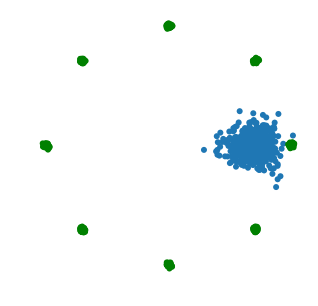

 20%|█▉        | 4999/25000 [03:15<13:39, 24.40it/s]

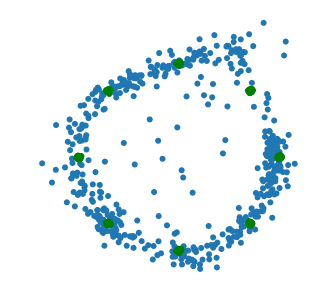

 40%|███▉      | 9999/25000 [06:28<08:41, 28.75it/s]

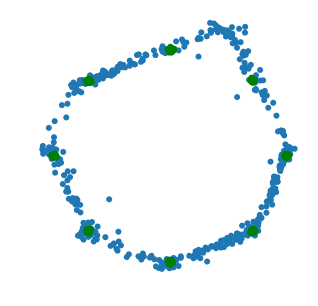

 60%|█████▉    | 14999/25000 [10:25<08:21, 19.93it/s]

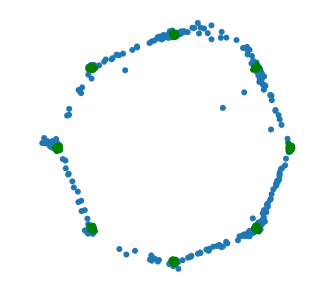

 80%|███████▉  | 19998/25000 [14:30<04:07, 20.24it/s]

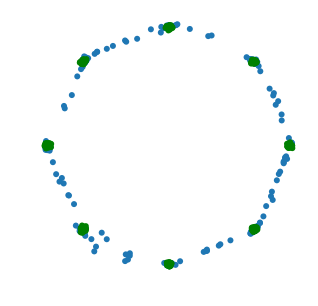

100%|██████████| 25000/25000 [18:37<00:00, 20.79it/s]


In [9]:
from tqdm import tqdm
xmax = 3
fs = []
frames = []
np_samples = []
n_batches_viz = 10
viz_every = params['viz_every']
for i in tqdm(range(params['max_iter'])):
    f, _, _ = sess.run([[loss, unrolled_loss], g_train_op, d_train_op])
    fs.append(f)
    if i % viz_every == 0:
        np_samples.append(np.vstack([sess.run(samples) for _ in range(n_batches_viz)]))
        xx, yy = sess.run([samples, data])
        fig = figure(figsize=(5,5))
        scatter(xx[:, 0], xx[:, 1], edgecolor='none')
        scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none')
        axis('off')
        if generate_movie:
            frames.append(mplfig_to_npimage(fig))
        show()

## Visualize results

In [10]:
import seaborn as sns

/home/tund/opt/anaconda3/envs/tensorflow_v1/lib/python3.5/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  # This is added back by InteractiveShellApp.init_path()


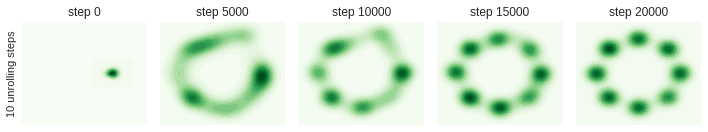

In [11]:
np_samples_ = np_samples[::1]
cols = len(np_samples_)
bg_color  = sns.color_palette('Greens', n_colors=256)[0]
figure(figsize=(2*cols, 2))
for i, samps in enumerate(np_samples_):
    if i == 0:
        ax = subplot(1,cols,1)
    else:
        subplot(1,cols,i+1, sharex=ax, sharey=ax)
    ax2 = sns.kdeplot(samps[:, 0], samps[:, 1], shade=True, cmap='Greens', n_levels=20, clip=[[-xmax,xmax]]*2)
    ax2.set_axis_bgcolor(bg_color)
    xticks([]); yticks([])
    title('step %d'%(i*viz_every))
ax.set_ylabel('%d unrolling steps'%params['unrolling_steps'])
gcf().tight_layout()

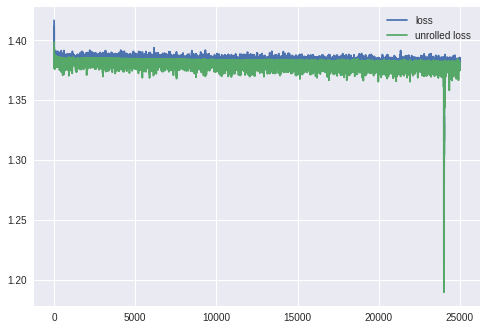

In [12]:
fs = np.array(fs)
plot(fs)
legend(('loss', 'unrolled loss'))

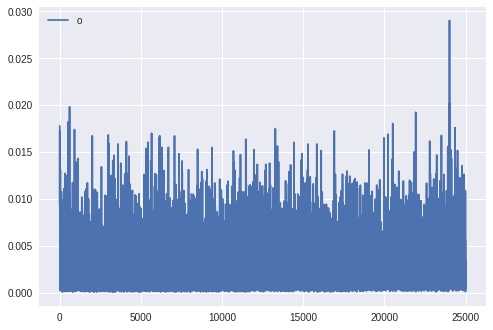

In [13]:
plot(fs[:, 0] - fs[:, 1])
legend('optimized loss - initial loss')

In [ ]:
#clip = mpy.ImageSequenceClip(frames[::], fps=30)
#clip.ipython_display()